# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

In [36]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Here again, the different functions from utils.rnn are in the file [rnn.py](./utils/rnn.py).

In [37]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple
from collections import Counter
import datasets as ds
from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [55]:
def load_imdb_datasets() -> tuple[ds.Dataset]:
    """
    Loads the IMDB dataset from the datasets library.
    Splits the train dataset into train, validation and test sets.
    Returns:
        datasets: list[ds.Dataset] - List of datasets
    """
    dataset = load_dataset("imdb")
    train_dataset = dataset["train"].train_test_split(
        stratify_by_column="label", test_size=0.2, seed=42
    )
    test_df = dataset["test"]
    train_df = train_dataset["train"]
    valid_df = train_dataset["test"]

    return (train_df, valid_df, test_df)

def build_vocabulary(dataset: ds.Dataset, tokenizer: Callable) -> Vocab:
    """
    Builds a vocabulary from a dataset.
    Args:
        dataset: ds.Dataset - Dataset to build vocabulary from
    Returns:
            vocab: Vocab - Vocabulary
    """
    tokens = tokenizer(" ".join(dataset["text"]))
    counter = Counter(tokens)
    vocabulary = vocab(counter, min_freq=10, specials=["<unk>", "<pad>"])
    vocabulary.set_default_index(vocabulary["<unk>"])

    return vocabulary

def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor(
        [vocabulary[token] for token in tokenizer(text)], dtype=torch.long
    )

def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    for i in range(0, len(X), batch_size):
        X_batch = nn.utils.rnn.pad_sequence(
            X[i : i + batch_size], batch_first=True, padding_value=pad_id
        )
        y_batch = torch.tensor(y[i : i + batch_size], dtype=torch.float32)
        yield X_batch, y_batch

def get_device() -> str:
    """
    Returns the device to use for training.
    Returns:
        device: str - Device to use for training
    """
    # Define CPU as default device
    device = "cpu"

    # Use Cuda acceleration if available (Nvidia GPU)
    if torch.cuda.is_available():
        device = "cuda:0"
    # Use Metal acceleration if available (MacOS)
    elif torch.backends.mps.is_available():
        device = "mps:0"
    
    return device

def evaluate(
    model: nn.Module,
    generator: Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
    device: str,
) -> Tuple[float, float, float, float]:
    """
    Evaluate a model on a given dataset.
    Args:
        model: a pytorch module.
        criterion: a loss function.
        generator: a generator of data.
        device: the device to use.
    Returns:
        A tuple of accuracy, precision, recall and f1-score.
    """
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in generator():
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_true.extend(y_batch.tolist())
            y_pred.extend(model(X_batch).round().squeeze(1).tolist())
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=None)
        recall = recall_score(y_true, y_pred, average=None)
        f1 = f1_score(y_true, y_pred, average=None)
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1:.3f}")
    return accuracy, precision, recall, f1

## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

### Load the dataset

First, we load the dataset and create the train, validation and test sets.

In [39]:
train_df, valid_df, test_df = load_imdb_datasets()

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

  0%|          | 0/3 [00:00<?, ?it/s]

Train set size: 20000
Validation set size: 5000
Test set size: 25000


### Create the vocabulary

In [40]:
tokenizer = get_tokenizer("basic_english")
vocabulary = build_vocabulary(train_df, tokenizer)

### Vectorize the inputs

In [41]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)
text_pipeline("This is a test!")

tensor([   9,  118,   17, 4089,  200])

Now we can map the datasets to their vectorized version.

In [42]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

### Create the batches

In [43]:
pad_token = '<pad>'
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

In [44]:
# Set the device to GPU (CUDA or Metal acceleration) if available, otherwise CPU.
device = get_device()

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [45]:
class RNN(nn.Module):
    """
    A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [46]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    Returns:
        A tuple:[best_model (by validation loss), training losses, validation losses].
    """
    # Initialize the losses.
    train_losses = []
    valid_losses = []
    # Initialize the best model.
    best_model = None
    best_valid_loss = np.inf

    for epoch in tqdm(range(n_epochs)):
        # Training mode.
        model.train(True)
        # Initialize the training loss.
        train_loss = 0.0
        # Iterate over the training batches.
        for X, y in tqdm(train_gen()):
            X = X.to(device)
            y = y.to(device)
            # Zero the gradients.
            optimizer.zero_grad()
            # model.zero_grad()
            # Forward pass.
            y_pred = model(X)
            # Compute the loss.
            loss = criterion(y_pred, y.unsqueeze(1))
            # Backward pass.
            loss.backward()
            # Update the weights.
            optimizer.step()
            # Update the training loss.
            train_loss += loss.item()
        train_loss /= len(list(train_gen()))
        # Validation mode.
        model.train(False)
        # Initialize the validation loss.
        valid_loss = 0.0
        # Iterate over the validation batches.
        with torch.no_grad():
          for X, y in valid_gen():
              X = X.to(device)
              y = y.to(device)
              # Forward pass.
              y_pred = model(X)
              # Compute the loss.
              loss = criterion(y_pred, y.unsqueeze(1))
              # Update the validation loss.
              valid_loss += loss.item()
        valid_loss /= len(list(valid_gen()))
        # Update the losses.
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Update the best model.
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model

        print(f"Epoch {epoch+1}/{n_epochs}: train loss: {train_loss:.4f}, valid loss: {valid_loss:.4f}")

    return best_model, train_losses, valid_losses

In [47]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [48]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 3, train_gen, valid_gen)

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1/3: train loss: 0.6945, valid loss: 0.6940


0it [00:00, ?it/s]

Epoch 2/3: train loss: 0.6935, valid loss: 0.6948


0it [00:00, ?it/s]

Epoch 3/3: train loss: 0.6937, valid loss: 0.7070


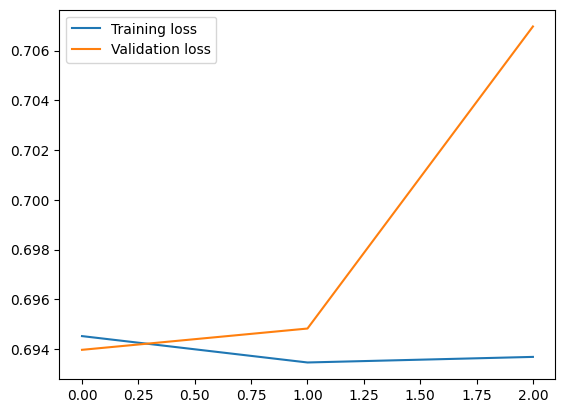

In [49]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## Do the following (5 points)
* **\[1 point\]** Add an accuracy function and report the accuracy of the training, validation, and test set.
* **\[2 points\]** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
  * Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
* **\[1 point\]** Implement a function which takes any text and returns the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).
* **\[Bonus\]** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * **Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.
* **\[1 point\]** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **\[Bonus\]** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

#### Accuracy Evaluation

In [56]:
# Evaluate the model on the train set.
accuracy, precision, recall, f1 = evaluate(model, train_gen, device)

Accuracy: 0.500


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: ignored

In [ ]:
# Evaluate the model on the validation set.
_ = evaluate(model, valid_gen, device)

In [ ]:
# Evaluate the model on the test set.
_ = evaluate(model, test_gen, device)

For this part of the practical, we also could not manage to find the solution for the training issue.